In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls "/content/gdrive/My Drive/RUL_code"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
data  simple  utils.py


In [ ]:
!pip install composeml==0.3

In [ ]:
!pip install featuretools==0.16

In [ ]:
import composeml as cp
import numpy as np
import pandas as pd
import featuretools as ft
import utils
import os

from tqdm import tqdm
from sklearn.cluster import KMeans

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


# New Section

In [ ]:
data_path = 'gdrive/My Drive/RUL_code/data/train_FD004.txt'
data = utils.load_data(data_path)

data.head()

Loaded data with:
61249 Recordings
249 Engines
21 Sensor Measurements
3 Operational Settings


,engine_no,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,index,time
index,,,,,,,,,,,,,,,,,,,,,
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670,0,2000-01-01 00:00:00
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552,1,2000-01-01 00:10:00
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213,2,2000-01-01 00:20:00
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176,3,2000-01-01 00:30:00
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754,4,2000-01-01 00:40:00


In [ ]:
def remaining_useful_life(df):
    return len(df) - 1

lm = cp.LabelMaker(
    target_entity='engine_no',
    time_index='time',
    labeling_function=remaining_useful_life,
)

label_times = lm.search(
    data.sort_values('time'),
    num_examples_per_instance=1,
    minimum_data=100,
    verbose=True,
)

label_times.head()

Elapsed: 00:00 | Remaining: 00:00 | Progress: 100%|██████████| engine_no: 249/249 


,engine_no,time,remaining_useful_life
id,,,
0,1,2000-01-01 16:40:00,220
1,2,2000-01-03 22:10:00,198
2,3,2000-01-06 00:00:00,206
3,4,2000-01-08 03:10:00,173
4,5,2000-01-10 00:50:00,92


In [ ]:
splits = 5
cutoff_time_list = []

for i in range(splits):
    sample = label_times.sample(n=249, random_state=i)
    sample.sort_index(inplace=True)
    cutoff_time_list.append(sample)

cutoff_time_list[0].head()

,engine_no,time,remaining_useful_life
id,,,
0,1,2000-01-01 16:40:00,220
1,2,2000-01-03 22:10:00,198
2,3,2000-01-06 00:00:00,206
3,4,2000-01-08 03:10:00,173
4,5,2000-01-10 00:50:00,92


In [ ]:
def make_entityset(data):
    es = ft.EntitySet('Dataset')

    es.entity_from_dataframe(
        dataframe=data,
        entity_id='recordings',
        index='index',
        time_index='time',
    )

    es.normalize_entity(
        base_entity_id='recordings',
        new_entity_id='engines',
        index='engine_no',
    )

    es.normalize_entity(
        base_entity_id='recordings',
        new_entity_id='cycles',
        index='time_in_cycles',
    )

    return es

In [ ]:
es = make_entityset(data)
es

Entityset: Dataset
  Entities:
    recordings [Rows: 61249, Columns: 28]
    engines [Rows: 249, Columns: 2]
    cycles [Rows: 543, Columns: 2]
  Relationships:
    recordings.engine_no -> engines.engine_no
    recordings.time_in_cycles -> cycles.time_in_cycles

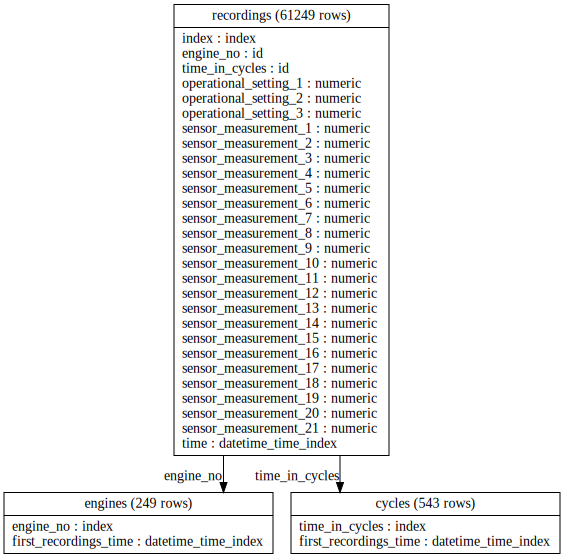

In [ ]:
es.plot()

In [ ]:
fm, features = ft.dfs(
    entityset=es,
    target_entity='engines',
    agg_primitives=['last', 'max', 'min'],
    trans_primitives=[],
    cutoff_time=label_times,
    max_depth=3,
    verbose=True,
)

fm.to_csv('simple_fm.csv')

Built 292 features
Elapsed: 01:57 | Progress: 100%|██████████


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

fm = pd.read_csv('simple_fm.csv', index_col='engine_no')
X = fm.copy().fillna(0)
y = X.pop('remaining_useful_life')

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=17)

medianpredict1 = [np.median(y_train) for _ in y_test]
mae = mean_absolute_error(medianpredict1, y_test)
print('Baseline by median label: Mean Abs Error = {:.2f}'.format(mae))

##


Baseline by median label: Mean Abs Error = 59.98


In [ ]:
from_train = es['recordings'].df['engine_no'].isin(y_train.index)
recordings_from_train = es['recordings'].df[from_train]
engines = recordings_from_train.groupby(['engine_no'])
median_life = np.median(engines.apply(lambda df: df.shape[0]))

from_test = es['recordings'].df['engine_no'].isin(y_test.index)
recordings_from_test = es['recordings'].df[from_test]
engines = recordings_from_test.groupby(['engine_no'])
life_in_test = engines.apply(lambda df: df.shape[0]) - y_test

medianpredict2 = median_life - life_in_test
medianpredict2 = medianpredict2.apply(lambda row: max(row, 0))
mae = mean_absolute_error(medianpredict2, y_test)
print('Baseline by median life: Mean Abs Error = {:.2f}'.format(mae))

Baseline by median life: Mean Abs Error = 59.98


In [ ]:
reg = RandomForestRegressor(n_estimators=100)
reg.fit(X_train, y_train)

preds = reg.predict(X_test)
scores = mean_absolute_error(preds, y_test)
print('Mean Abs Error: {:.2f}'.format(scores))

high_imp_feats = utils.feature_importances(X, reg, feats=10)

Mean Abs Error: 50.15
1: MIN(recordings.sensor_measurement_11) [0.084]
2: MAX(recordings.sensor_measurement_4) [0.059]
3: MIN(recordings.cycles.LAST(recordings.sensor_measurement_11)) [0.057]
4: MAX(recordings.cycles.LAST(recordings.sensor_measurement_4)) [0.038]
5: MAX(recordings.sensor_measurement_15) [0.031]
6: MAX(recordings.cycles.LAST(recordings.sensor_measurement_15)) [0.031]
7: MAX(recordings.cycles.LAST(recordings.operational_setting_2)) [0.028]
8: MAX(recordings.cycles.LAST(recordings.sensor_measurement_13)) [0.024]
9: LAST(recordings.sensor_measurement_14) [0.022]
10: MAX(recordings.cycles.LAST(recordings.sensor_measurement_3)) [0.022]
-----



In [ ]:
data2 = utils.load_data('gdrive/My Drive/RUL_code/data/test_FD004.txt')
es2 = make_entityset(data2)

fm2 = ft.calculate_feature_matrix(
    entityset=es2,
    features=features,
    verbose=True,
)

fm2.head()

Loaded data with:
41214 Recordings
248 Engines
21 Sensor Measurements
3 Operational Settings
Elapsed: 00:02 | Progress: 100%|██████████


,LAST(recordings.sensor_measurement_11),LAST(recordings.sensor_measurement_21),LAST(recordings.operational_setting_3),LAST(recordings.operational_setting_1),LAST(recordings.sensor_measurement_9),LAST(recordings.index),LAST(recordings.sensor_measurement_4),LAST(recordings.sensor_measurement_10),LAST(recordings.sensor_measurement_17),LAST(recordings.sensor_measurement_20),...,MIN(recordings.cycles.MAX(recordings.operational_setting_2)),MIN(recordings.cycles.MAX(recordings.sensor_measurement_3)),MIN(recordings.cycles.MIN(recordings.sensor_measurement_18)),MIN(recordings.cycles.MIN(recordings.sensor_measurement_2)),MIN(recordings.cycles.MAX(recordings.sensor_measurement_14)),MIN(recordings.cycles.LAST(recordings.sensor_measurement_8)),MIN(recordings.cycles.LAST(recordings.sensor_measurement_6)),MIN(recordings.cycles.MIN(recordings.sensor_measurement_20)),MIN(recordings.cycles.MIN(recordings.sensor_measurement_12)),MIN(recordings.cycles.MIN(recordings.sensor_measurement_21))
engine_no,,,,,,,,,,,,,,,,,,,,,
1,36.87,8.6329,60.0,25.0070,8023.10,229,1046.41,0.94,308,14.41,...,0.8411,1589.26,1915,535.42,8143.86,1915.22,5.71,10.19,128.26,6.1453
2,42.29,6.4325,100.0,41.9989,8310.36,382,1133.55,1.02,331,10.58,...,0.8416,1590.43,1915,535.42,8143.86,1915.22,5.71,10.19,128.26,6.1453
3,41.82,6.3488,100.0,42.0005,8331.13,523,1118.90,1.02,330,10.61,...,0.8416,1590.43,1915,535.42,8143.86,1915.22,5.71,10.19,128.26,6.1453
4,36.57,8.5696,60.0,25.0018,8012.46,731,1038.53,0.94,306,14.41,...,0.8415,1589.74,1915,535.42,8143.86,1915.22,5.71,10.19,128.26,6.1453
5,37.11,8.6248,60.0,25.0039,8011.76,782,1052.52,0.94,307,14.19,...,0.8418,1590.43,1915,535.42,8143.86,1915.22,5.71,10.19,128.73,6.1453


In [ ]:
X = fm2.copy().fillna(0)

y = pd.read_csv(
    'gdrive/My Drive/RUL_code/data/RUL_FD004.txt',
    sep=' ',
    header=None,
    names=['remaining_useful_life'],
    index_col=False,
)

preds2 = reg.predict(X)
mae = mean_absolute_error(preds2, y)
print('Mean Abs Error: {:.2f}'.format(mae))

medianpredict1 = [np.median(y_train) for _ in preds2]
mae = mean_absolute_error(medianpredict1, y)
print('Baseline by median label: Mean Abs Error = {:.2f}'.format(mae))

engines = es2['recordings'].df.groupby(['engine_no'])
medianpredict2 = median_life - engines.apply(lambda df: df.shape[0])
medianpredict2 = medianpredict2.apply(lambda row: max(row, 0))
mae = mean_absolute_error(medianpredict2, y)
print('Baseline by median life: Mean Abs Error = {:.2f}'.format(mae))

Mean Abs Error: 59.32
Baseline by median label: Mean Abs Error = 59.34
Baseline by median life: Mean Abs Error = 50.29
